(content:references:images_part4)=
# Images Part 4: *Upscaling the Cosmic Web*

***Author: Marc Hon***


Cosmological simulations are forward models that evolve primordial density fluctuations under a chosen cosmology and baryonic physics. By following the evolution of gas, dark matter, stars, and black-holes, these simulations predict observable structure known as the **Cosmic Web**— large scale structure in our Universe appearing as nodes (halos), filaments, sheets, and voids. Embedded within these structures are the basic units of cosmic structure, namely **galaxies**. 



```{figure} images/scales.jpg
---
height: 400px
width: 700px
name: scales
---
The hierarchy of structure in the Universe. Source: [STRUCTURES Blog](https://structures.uni-heidelberg.de/blog/posts/2022_12_cw/)
```

It is for this reason that understanding the formation and evolution of galaxies is highly relevant for testing models of cosmology, including $\Lambda$CDM. Doing this requires creating simulated galaxies that are as detailed and realistic as possible, and comparing them to galaxies observed in the Universe. One example of such simulations is [**IllustrisTNG**](https://www.tng-project.org): a cosmological hydrodynamical simulation that follows dark matter, gas, stars, and black holes self-consistently as the Universe expands. These simulations are computationally very expensive because they generate and track physical quantities across billions of resolution elements.

```{figure} images/ilustris.png
---
height: 350px
width: 850px
name: ilustris
---

(Left) Different scales of the Illustris-TNG simulations spanning cubic volumes of roughly 50, 100, and 300 Mpc side length. (Right) Comparison of various cosmological simulations, showing the tradeoff in simulation volume versus resolution.  Adapted from the [IllustrisTNG project](https://www.tng-project.org/about/).
```

Cosmological simulations have types of resolution scales to consider: mass resolution (mass per element) and spatial resolution (smallest scale tracked). In a fixed box, making either finer will sharply increase the compute cost of the simulation. A common compromise is to run a coarser simulation and add small-scale detail afterward, for example by re-simulating selected regions (“zoom-ins”). Another approach, which uses machine learning, is to **upscale a coarser simulation by applying super-resolution techniques**, which we will tackle here. The implementation of this pedagogical work is adapted from the [IAIFI 2024 ML Hackathon tutorial](https://github.com/yueyingn/ML-Hackathon-2024/tree/main).


## Dataset: Cosmology and Astrophysics with MachinE Learning Simulations (CAMELS)

[CAMELS](https://camels.readthedocs.io/en/latest/#) is a large suite of N-body and state-of-the-art (magneto-)hydrodynamic simulations tailored towards machine learning (ML). The CAMELS data are readily packaged in the [CAMELS Multifield Dataset (CMD)](https://camels-multifield-dataset.readthedocs.io/en/latest/index.html), which includes a set of labels/parameters per 2D map. 

In [3]:
import os, random
import scienceplots
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import h5py, torch

from pathlib import Path
from matplotlib import cm
from matplotlib.colors import Normalize
from torch import nn, autograd, Tensor, einsum, nn, pi, softmax
from torchinfo import summary
from typing import Optional, Tuple
from torchvision.transforms import Resize as VisionResize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch.distributions.normal import Normal
from tqdm import trange
from torch.special import expm1

plt.style.use('science'); fs=15

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter4' / 'data'

In this Section, we will use 2D maps of the Dark Matter density field generated by the IllustrisTNG simulations. These maps are 'snapshots' of the simulations at given instance of time, which is the present day given a redshift of $z=0$.

In [2]:
simPath = '/Maps_Mcdm_IllustrisTNG_CV_z=0.00.npz'
dm_map = np.load(str(data_folder_path) + simPath)['dm_map']

dm_map = np.log10(dm_map)
dm_map = (dm_map - dm_map.mean()) / dm_map.std() # Data Normalization
print ("Data Shape:",dm_map.shape)

Data Shape: (405, 256, 256)


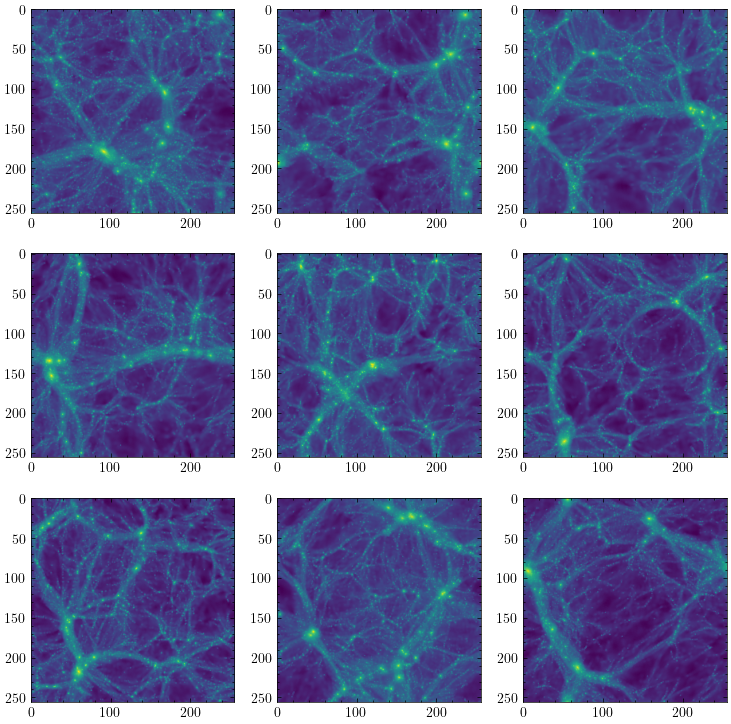

In [3]:
f, axes = plt.subplots(3,3,figsize=(9,9))
for i in range(0,9):
    axes.flat[i].imshow(dm_map[i])

### Image Transformations
In [](content:references:images_part2) and [](content:references:images_part3), spatial transformations were introduced to encourage deep learning networks to learn physically meaningful features from images. Such transformations are again applied to this dataset to improveness the robustness of the training approach.

In [4]:
class Translate(object):

    def __init__(self, ndim):
        self.ndim = ndim
        
    def __call__(self, sample):
        in_img = sample 
        
        shift_dims = tuple(np.arange(self.ndim)-self.ndim)
        shift_pixels = tuple([torch.randint(in_img.shape[d], (1,)).item() for d in shift_dims])

        in_img = torch.roll(in_img, shift_pixels, dims=shift_dims)
        
        return in_img
    

class Flip(object):

    def __init__(self, ndim):
        self.axes = None
        self.ndim = ndim

    def __call__(self, sample):
        assert self.ndim > 1, "flipping is ambiguous for 1D scalars/vectors"

        self.axes = torch.randint(2, (self.ndim,), dtype=torch.bool)
        self.axes = torch.arange(self.ndim)[self.axes]

        in_img = sample

        if in_img.shape[0] == self.ndim: 
            in_img[self.axes] = -in_img[self.axes]

        shifted_axes = (1 + self.axes).tolist()
        in_img = torch.flip(in_img, shifted_axes)

        return in_img
    

class Permutate(object):

    def __init__(self, ndim):
        self.axes = None
        self.ndim = ndim

    def __call__(self, sample):
        assert self.ndim > 1, "permutation is not necessary for 1D fields"

        self.axes = torch.randperm(self.ndim)
        
        in_img = sample

        if in_img.shape[0] == self.ndim:  # permutate vector components
            in_img = in_img[self.axes]

        shifted_axes = [0] + (1 + self.axes).tolist()
        in_img = in_img.permute(shifted_axes)

        return in_img
    
ndim = 2
train_transforms = transforms.Compose([Translate(ndim), Flip(ndim), Permutate(ndim)]) 

The resulting transformations to be used in training will be a combination of the `Translate`, `Flip`, and `Permutate` transformations chained in sequence.

```{admonition} Interpreting Image Transforms
:class: tip

What do the `Translate`, `Flip`, and `Permutate` transformations do an input image individually?
How might these transformations help the model see *different versions* of the same image?  

```

The transformations are applied in a Dataset, which additionally creates two copies of transformed input images:

- A **low resolution** image, whose size is controlled by the parameter `lr_size`
- A **high resolution** image, whose size is controlled by the parameter `hr_size`

In [5]:
class SupResDataset(Dataset):
    """
    Make the pairs of LR, HR img pairs
    """
    def __init__(self, imgs, lr_size, hr_size, transform=None):
        self.imgs = imgs
        self.transform = transform
        self.lr_resize = VisionResize(lr_size, antialias=False)
        self.hr_resize = VisionResize(hr_size, antialias=False)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.Tensor(self.imgs[idx]).unsqueeze(0)
    
        if self.transform is not None:
            img = self.transform(img)
        
        LR_img = self.lr_resize(img).squeeze(0)
        HR_img = self.hr_resize(img).squeeze(0)
        return self.imgs[idx], LR_img, HR_img

In [63]:
# create the dataset
dataset = SupResDataset(dm_map, lr_size=32, hr_size=128, transform=train_transforms)

# split dataset for training and validation
train_set_size = int(len(dataset) * 0.9)
val_set_size = len(dataset) - train_set_size
train_dataset, val_dataset = random_split(dataset, [train_set_size, val_set_size])

# Create train and validation data loaders
BATCH_SIZE = 4
train_iterator = DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
val_iterator = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

```{caution}

As defined by `hr_size=128`, the 'high-resolution' images are still downsampled from the images' native resolution of $256\times256$, but serve their purpose of being upsampled versions of the low-resolution images in the training data.

```
A sample visualization of the image transformation is as follows:

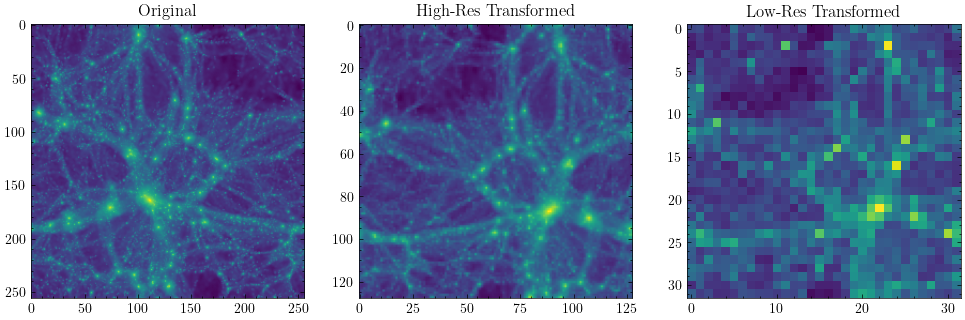

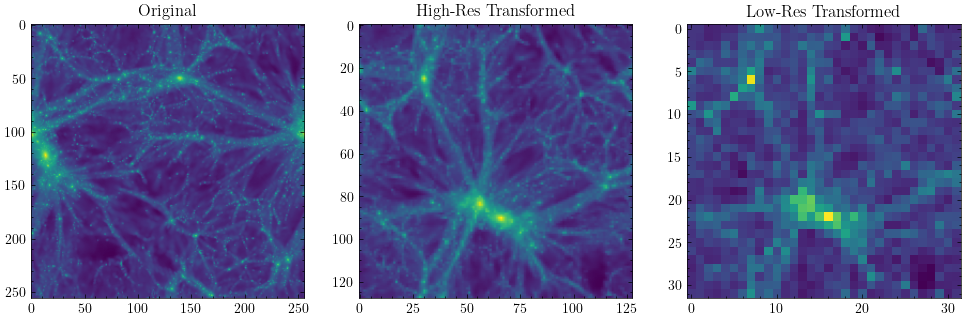

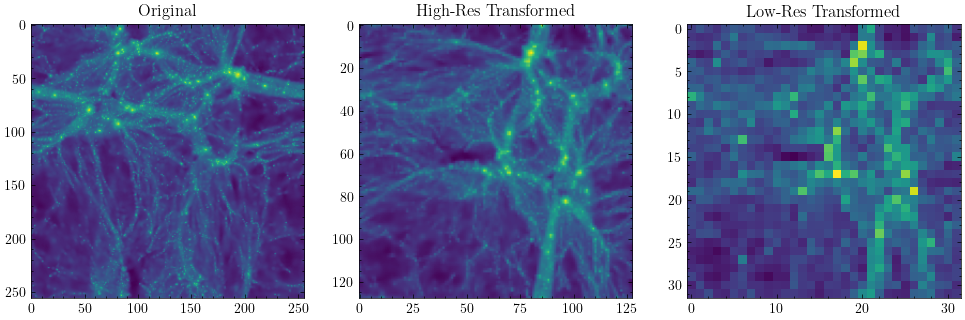

In [19]:
iter_train = iter(train_iterator)
for n in range(3):
    ori_img, lr_img, hr_img = next(iter_train)
    fig, ax = plt.subplots(ncols=3,figsize=(12,8))
    ax[0].imshow(ori_img[0].squeeze())
    ax[0].set_title('Original')
    ax[1].imshow(hr_img[0].squeeze())
    ax[1].set_title('High-Res Transformed')
    ax[2].imshow(lr_img[0].squeeze())
    ax[2].set_title('Low-Res Transformed')

## Diffusion Models

> **Diffusion models are a family of probabilistic generative models that progressively destruct data by injecting noise, then learn to reverse this process for sample generation.** [Yang et al. (2024)](https://arxiv.org/pdf/2209.00796)


### Denoising Diffusion Probabilistic Model (DDPM)

A [DDPM](https://arxiv.org/pdf/2006.11239) makes use of two Markov chains across steps $t \in [0, 1, ..., T]$:

- A forward chain that gradually adds noise to the data ($\mathbf{x}_0$) until the signal is destroyed. This is done by generating a sequence $\mathbf{x}_1$, $\mathbf{x}_2$, ..., $\mathbf{x}_T$, with transition kernel $q\,(\mathbf{x}_t, \mathbf{x}_{t-1})$.

- A reverse chain that converts noise back to data. This is done by **learning** the transition kernels running in the opposite direction, namely **$p_{\theta}\,(\mathbf{x}_{t-1}, \mathbf{x}_{t})$**.

```{figure} images/ddpm.png
---
height: 250px
width: 700px
name: ddpm
---
Schematic of a Denoising Diffusion Probabilistic Model. Source: [What Are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
```
This Section will implement a DDPM, where we will examine individual elements.

### Noise Scheduling - Discrete Time

A schedule is the plan for how much noise we add at each step.

In classic DDPM, this is done using a sequence $\{{\beta_t}\}_{t=1}^T$ with $0<\beta_t<1$:

$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) \;=\; \mathcal{N}\!\big(\sqrt{1-\beta_t}\,\mathbf{x}_{t-1},\; \beta_t I\big),\quad 0<\beta_t<1.
$$

Now by defining

$$
\alpha_t \equiv 1-\beta_t, \qquad \bar{\alpha}_t \equiv \prod_{i=1}^{t}\alpha_i .
$$

we may sample $\mathbf{x}_t$ *in one shot* from $\mathbf{x}_0$:

$$
\mathbf{x}_t \;=\; \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0 \;+\; \sqrt{1-\bar{\alpha}_t}\,\varepsilon,\qquad \varepsilon\sim\mathcal{N}(0,I),
$$

where $\varepsilon$ is noise.

### Noise Scheduling - Continuous Time

Instead of adding noise in discrete steps, we may add it in **continuous time** through a smooth function $\gamma(t)$ known as the log-SNR schedule.

$$
\alpha^2(t) \;=\; \mathrm{sigmoid}\!\big(-\gamma(t)\big), 
\qquad
\sigma^2(t) \;=\; \mathrm{sigmoid}\!\big(\gamma(t)\big),
$$

```{math}
:label: eq-vp-identity
\mathbf{x}_t \;=\; \alpha(t)\,\mathbf{x}_0 \;+\; \sigma(t)\,\varepsilon,\qquad \varepsilon\sim\mathcal{N}(0,I).
```


```{admonition} Interpretation of Continuous Time Scheduling
:class: note

In the simplest cases, $\gamma(t)$ is defined as:

$$
\gamma(t) = \gamma_{\mathrm{min}} + (\gamma_{\mathrm{max}} - \gamma_{\mathrm{min}}) \times t
$$

where $\gamma_{\mathrm{min}}$ and $\gamma_{\mathrm{max}}$ are constants that are set to saturate the sigmoid function at $t=0$ and $t=1$, respectively. This allows equation [](eq-vp-identity) to control the addition of noise over time. 

- At $t=0$, $\gamma(t=0) = \gamma_{\mathrm{min}}$
    - $\rightarrow \alpha^2(t=0) \approx 1; \qquad \sigma^2(t=0) \approx 0$
    - $\rightarrow \mathbf{x}_T \approx \mathbf{x}_0$
    
    
- At $t=1$, $\gamma(t=1) = \gamma_{\mathrm{max}}$
    - $\rightarrow \alpha^2(t=1) \approx 0; \qquad \sigma^2(t=1) \approx 1$
    - $\rightarrow \mathbf{x}_T \approx \epsilon \sim \mathcal{N}(0,I)$

Early steps keep signal from the data high (large $\alpha$, small $\sigma$), while late steps drown it in noise (small $\alpha$, large $\sigma$) until $\mathbf{x}_T$ is nearly Gaussian. 

This method of adding noise is described to be **variance preserving**, with $\alpha^2(t) + \sigma^2(t) = 1$. 

The **signal-to-noise** is defined as $\mathrm{SNR}(t) = \alpha^2/\sigma^2 = \exp(-\gamma(t))$.
```

<!-- such that the total variance of $\mathbf{x}_T$ stays normalized.  -->

In [7]:
class FixedLinearSchedule(nn.Module):
    def __init__(self, gamma_min=-13.3, gamma_max=13.3):
        super().__init__()
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max

    def forward(self, t):
        return self.gamma_min + (self.gamma_max - self.gamma_min) * t

def variance_preserving_map(x, times, gamma_fn, noise=None):
    """
    Variance-preserving forward noising: x_t = alpha(t) * x_0 + sigma(t) * eps
    where alpha^2 = sigmoid(-gamma), sigma^2 = sigmoid(gamma).
    """
    with torch.enable_grad():  # keep grads for loss terms downstream
        times = times.view((times.shape[0],) + (1,) * (x.ndim - 1))
        gamma_t = gamma_fn(times)

    alpha = torch.sqrt(torch.sigmoid(-gamma_t))
    scale = torch.sqrt(torch.sigmoid(gamma_t))

    if noise is None:
        noise = torch.randn_like(x)

    return alpha * x + scale * noise, gamma_t

```{admonition} Exercise: Corrupting an Image
:class: note

Let's observe a sequence of noise corruption to an image of dark matter simulation using `variance_preserving_map`.
At the same time, we want to calculate the noise statistics, and we can do this by taking any image from the simulation, and duplicating it $B$ times, which each duplicate corrupted by an independent noise draw.

1. Show, for $t\in[0, 1]$, sequential images from the gradual increment of noise. Generate **at least 10** images in the sequence.

2. For each $t$, compute across $B$ independent noise draws:
 - The **mean empirical SNR** 
 - The **total variance** of $\mathbf{x}_t$ (averaged over pixels)

Do the SNR values across the sequence make sense? What do you notice about the total variance of the image across the sequence? To begin, you may use the following code hint:

```python
torch.manual_seed(1)
C, H, W = 1, 64, 64
img = torch.Tensor(dm_map[137]).unsqueeze(0).unsqueeze(0)    # a single "image"
B = 512                                     # many draws of noise at each t

def var_over_pixels(x): # per-sample pixel variance
    return x.view(x.size(0), -1).var(dim=1, unbiased=False)  

for t in np.linspace(0, 1, 10):
    # replicate the same image B times; draw fresh noise each time
    x0_batch = img.expand(B, -1, -1, -1).clone()
    times    = torch.full((B,), t)
    x_t, g_t = variance_preserving_map(x0_batch, times, FixedLinearSchedule())
    
    ### CODE FOR PLOTTING IMAGES AND PRESENTING STATISTICS HERE ###
```

```{figure} images/corruption.png
---
height: 200px
width: 700px
name: corruption
---
Example of a forward chain.
```

## Loss Functions

### Diffusion Loss - Standard DDPM

The overall goal in a **standard DDPM** is to predict the Gaussian noise $\varepsilon$ that corrupted $\mathbf{x}_0$ at a randomly chosen diffusion step $t$.

$$
\mathcal{L}_{\text{simple}}
\;=\;
\mathbb{E}_{t,\,\mathbf{x}_0,\,\varepsilon}
\big[
\|\varepsilon - \varepsilon_\theta(\mathbf{x}_t, t)\|_2^2
\big],
\qquad
\mathbf{x}_t \;=\; \sqrt{\bar\alpha_t}\,\mathbf{x}_0 \;+\; \sqrt{1-\bar\alpha_t}\,\varepsilon.
$$

Predicting $\varepsilon$ provides the denoiser for $\mathbf{x}_0$ and the **score** $\nabla_{\mathbf{x}_t} \log q(\mathbf{x}_t)$ for the reverse chain.


```{admonition} The Score Function
:class: tip

For each noise level $t$, the **score** is the gradient of the log density of the corrupted data:

> $s_t \equiv \nabla_{x_t} \log q(\mathbf{x}_t)$

Its interpretation is that of a vector field pointing towards higher probability of the data distribution at noise level $t$. 

Recall that 

$$
\mathbf{x}_t \;=\; \alpha(t)\,\mathbf{x}_0 \;+\; \sigma(t)\,\varepsilon,\qquad \varepsilon\sim\mathcal N(0,I),
\quad q(\mathbf{x}_t|\mathbf{x}_0) \sim\mathcal N(\mathbf{x}_t;\mathbf{x}_0,I)
$$

and 

$$
\alpha^2(t)=\mathrm{sigmoid}\!\big(-\gamma(t)\big),
\qquad
\sigma^2(t)=\mathrm{sigmoid}\!\big(\gamma(t)\big).
$$

Now, the score-matching identity (see Eqn. 8 of [Yang et al. (2024)](https://arxiv.org/pdf/2209.00796), also Section 1.2 of [Bortoli et al. (2024)](https://arxiv.org/pdf/2402.08667)), presents the score as the following:

$$
s_t(\mathbf{x}_t) \equiv \nabla_{x_t} \log q(\mathbf{x}_t)
\;=\;\frac{\mathbb E[\alpha(t)\,\mathbf{x}_0\,|\,\mathbf{x}_t]-\mathbf{x}_t}{\sigma^2(t)}
\;=\;-\frac{1}{\sigma(t)}\,\mathbb E[\varepsilon\,|\,\mathbf{x}_t].
$$

The model predicts  $\hat\varepsilon_\theta(x_t,t)$, which converges to $\mathbb E[\varepsilon\,|\,\mathbf{x}_t]$ during training. Therefore, the score 

$$
\hat s_t(\mathbf{x}_t)\;\approx\;-\dfrac{\hat\varepsilon_\theta(\mathbf{x}_t,t)}{\sigma(t)}.
$$

Crucially, $\sigma(t)$ is known from the schedule, not predicted. Rearranging the equation for $\mathbf{x}_t$, we get the denoiser for the clean data $\mathbf{x}_0$:

$$
\hat{\mathbf{x}}_0(\mathbf{x}_t,t)
\;=\;\frac{\mathbf{x}_t-\sigma(t)\,\hat\varepsilon_\theta(\mathbf{x}_t,t)}{\alpha(t)}
\;=\;\frac{\mathbf{x}_t+\sigma^2(t)\,\hat s_t(\mathbf{x}_t)}{\alpha(t)}.
$$

```

### Diffusion Loss - Continuous Time

As $t\in[0,1]$, it is tempting to simply set a noising/denoising schedule that steps forward linearly in time. However, by doing so, the image very quickly loses SNR, as shown below.

Text(0, 0.5, '$\\log_{10}$ SNR')

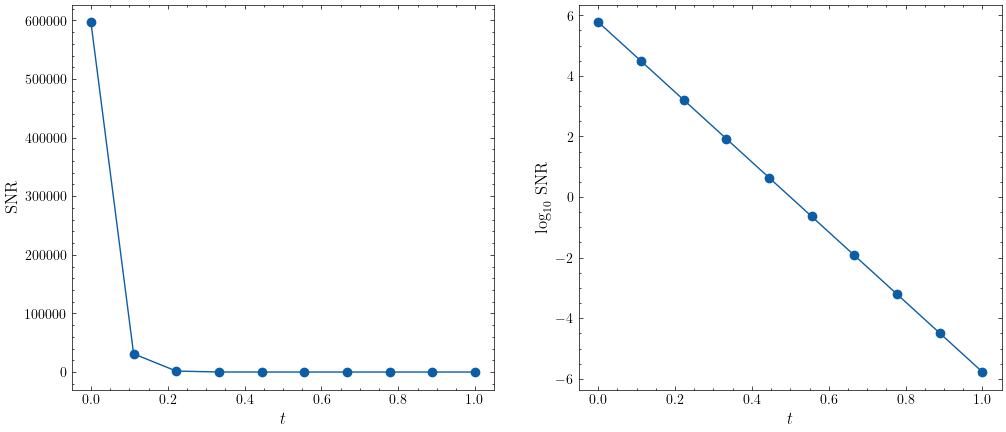

In [27]:
torch.manual_seed(1)
C, H, W = 1, 64, 64
img = torch.Tensor(dm_map[137]).unsqueeze(0).unsqueeze(0)    
B = 512                                   

def var_over_pixels(x): 
    return x.view(x.size(0), -1).var(dim=1, unbiased=False)  

snrs = []; timesteps = np.linspace(0, 1, 10)
for t in timesteps:
    x0_batch = img.expand(B, -1, -1, -1).clone()
    times    = torch.full((B,), t)
    x_t, g_t = variance_preserving_map(x0_batch, times, FixedLinearSchedule())
    snrs.append(torch.exp(-g_t.squeeze()[0]).numpy())
fig = plt.figure(figsize=(12,5)); ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax1.plot(timesteps, snrs, 'o-'); ax2.plot(timesteps, np.log10(snrs), 'o-')   
ax1.set_xlabel('$t$', fontsize=fs-3); ax2.set_xlabel('$t$', fontsize=fs-3)
ax1.set_ylabel('SNR', fontsize=fs-3); ax2.set_ylabel('$\\log_{10}$ SNR', fontsize=fs-3); plt.show()

Ultimately, we want to parameterize our loss to care about predictions average error by **noise level**, not by an arbitrary time label. Because of this, $\gamma_t$, the log-SNR, is used to parameterize the loss as a sum over timestamps **weighted by log-SNR**:


$$
\mathcal{L}_{\text{diff,disc}}
\;\approx\;
\mathbb{E}_{\mathbf{x}_0,\varepsilon}\!\left[
\sum_{t=1}^{T}
\tfrac{1}{2}\,
\big[
\|\varepsilon-\varepsilon_\theta(\mathbf{x}_t,t)\|\big]_2^2\;
\big(\gamma_t-\gamma_{t-1}\big)
\right].
$$


This can be taken to the limit as $T\to\infty$, whereby the sum above becomes

$$
\mathcal{L}_{\text{diff}}
\;=\;
\mathbb{E}_{\mathbf{x}_0,\varepsilon}\!\left[
\int_{0}^{1}
\tfrac{1}{2}\,
\big[
\|\varepsilon-\varepsilon_\theta(\mathbf{x}_t,t)\|\big]_2^2\;
\frac{d\gamma(t)}{dt}\,dt
\right],
\qquad
\mathbf{x}_t=\alpha(t)\,\mathbf{x}_0+\sigma(t)\,\varepsilon.
$$

The following implements the continuous time version of the diffusion loss:

<!-- #BPD  -->
<!-- The ELBO/KL terms are in nats (natural log). To report the conventional metric and to make losses comparable across resolutions, you divide by D and convert nats→bits by dividing by log⁡2 -->

In [8]:
def get_diffusion_loss(
    gamma_t,
    times,
    pred_noise,
    noise,
    bpd_factor):

    gamma_grad = autograd.grad(  # gamma_grad shape: (B, )
        gamma_t,  # (B, )
        times,  # (B, )
        grad_outputs=torch.ones_like(gamma_t),
        create_graph=True,
        retain_graph=True,
    )[0]
    pred_loss = (
        ((pred_noise - noise) ** 2).flatten(start_dim=1).sum(axis=-1)
    )  # (B, )
    return bpd_factor * 0.5 * pred_loss * gamma_grad

### Endpoint Loss: $t=1$

At $t=1$, conditioned on $\mathbf{x}_0$, we have

$$
\mathbf{x}_{t=1} \mid \mathbf{x}_0 \sim \mathcal N\,(\alpha_{t=1}\,\mathbf{x}_0,\ \sigma^2_{t=1}\,I)
$$

We need this to match the constraint at $t=1$, namely that the **end result of the forward chain is noise**:

$$
\mathbf{x}_{t=1} \approx \epsilon \sim \mathcal{N}(0,I)
$$

By defining, 

$$
\mu_1=\alpha_{t=1}\,\mathbf{x}_0,\ \ \sigma_1^2=\sigma^2_{t=1},
$$


the following loss explicitly enforces this constraint using the K-L Divergence between the Gaussian distribution predicted by the diffusion model and the normal distribution expected at $t=1$:

$$
\mathrm{KL}\!\left(q(\mathbf{x}_{t=1}\mid \mathbf{x}_{0})\;\|\;p(\mathbf{x}_{t=1})\right)
=\mathrm{KL}\!\left(\mathcal N(\mu_1,\sigma_1^2 I)\;\|\;\mathcal N(0,I)\right).
$$


The KL-loss in the following is a consequence of measuring the divergence with respect to a normal distribution, derived in Equation [](kl-gaussian) in [](content:references:eclipse_part4)

$$
\mathrm{KL}=\tfrac12\Big(\sigma_1^2+\mu_1^2-\log\sigma_1^2-1\Big).
$$

In [9]:
def kl_std_normal(mean_squared, var):
    return 0.5 * (var + mean_squared - torch.log(var.clamp(min=1e-15)) - 1.0)

def get_latent_loss(
    gamma_fn,
    x,
    bpd_factor):

    gamma_1 = gamma_fn(torch.tensor([1.0], device=x.device))
    sigma_1_sq = torch.sigmoid(gamma_1)
    mean_sq = (1 - sigma_1_sq) * x**2
    return bpd_factor * kl_std_normal(mean_sq, sigma_1_sq).flatten(start_dim=1).sum(
        axis=-1
    )

```{admonition} Applying the Variance-Preserving Identity
:class: tip

The code above uses the following identity to simplify the expression to using only $\sigma_1$:

$$
\alpha_{t=1}^2+\sigma_1^2=1 \qquad \text{(variance-preserving)} \qquad \;\;\Rightarrow\;\;
\mu_1^2=(\alpha_{t=1} \mathbf{x}_0)^2=\alpha_{t=1}^2 \mathbf{x}_0^2=(1-\sigma_1^2)\,\mathbf{x}_0^2.
$$
```

### Endpoint Loss: $t=0$

The $t=0$ loss is a **data-likelihood** term: we draw $z_0 \sim q(z_0\mid \mathbf{x}_0)$ from the forward process and require the observation model $p(\mathbf{x}_0\mid z_0)$ to assign high probability to the observed $\mathbf{x}_0$. 

Mathematically, the objective is:

$$
\mathcal{L}_{\text{recon}}
\;=\;
-\;\mathbb{E}_{q(z_0\mid x_0)}\big[\log p(\mathbf{x}_0\mid z_0)\big]
$$

Near $t=0$,

$$
z_0 \;=\; \alpha_0\,\mathbf{x}_0 \;+\; \sigma_0\,\varepsilon,\qquad
\sigma_0^2 \approx 0,\ \ \alpha_0^2 \approx 1,
\quad\Rightarrow\quad
\frac{z_0}{\alpha_0} \;\approx\; \mathbf{x}_0.
$$


$$
\log p(\mathbf{x}_0 \mid z_0)\;\approx\;\log \mathcal N\!\big(\mathbf{x}_0;\ z_0/\alpha_0,\ \texttt{data_noise}^2 I\big).
$$


In [10]:
def get_reconstruction_loss(
    x,
    bpd_factor,
    gamma_fn,
    data_noise = 1e-3,
):
    noise_0 = torch.randn_like(x)
    times = torch.tensor([0.0], device=x.device)
    z_0, gamma_0 = variance_preserving_map(
        x,
        times=times,
        gamma_fn=gamma_fn,
        noise=noise_0,
    )
    # Generate a sample for z_0 -> closest to the data
    alpha_0 = torch.sqrt(torch.sigmoid(-gamma_0))
    z_0_rescaled = z_0 / alpha_0
    return bpd_factor *\
 Normal(loc=z_0_rescaled, scale=data_noise).log_prob(x).flatten(start_dim=1).sum(axis=-1)

Putting all the losses together, we have:

In [11]:
def sample_times(
    self,
    batch_size: int,
    device: str,
) -> Tensor:
    """Sample diffusion times for batch, used for monte carlo estimates

    Args:
        batch_size (int): size of batch

    Returns:
        Tensor: times
    """
    t0 = np.random.uniform(0, 1 / batch_size)
    times = torch.arange(t0, 1.0, 1.0 / batch_size, device=device)

    return times


def get_loss(denoising_model,
             gamma_fn,
             sample_times,
             variance_preserving_map,
             get_diffusion_loss,
             get_latent_loss,
             get_reconstruction_loss, x,
             conditioning= None, noise= None):
    
    bpd_factor = 1 / (np.prod(x.shape[1:]) * np.log(2))
    
    # Sample from q(x_t | x_0) with random t
    
    batch_size = x.shape[0]
    t0 = np.random.uniform(0, 1 / batch_size)
    times = torch.arange(t0, 1.0, 1.0 / batch_size, device=x.device).requires_grad_(True)
    
    if noise is None:
        noise = torch.randn_like(x)
        
    # Forward noising
    x_t, gamma_t = variance_preserving_map(x=x, times=times, gamma_fn=gamma_fn, noise=noise)
    
    # Predict noise added
    pred_noise = denoising_model(
        x_t,
        conditioning=conditioning,
        g_t=gamma_t.squeeze(),
    )
    
    
    diffusion_loss = get_diffusion_loss(
        gamma_t=gamma_t,
        times=times,
        pred_noise=pred_noise,
        noise=noise,
        bpd_factor=bpd_factor,
    )

    latent_loss = get_latent_loss(
        gamma_fn = gamma_fn,
        x=x,
        bpd_factor=bpd_factor,
    )

    recons_loss = get_reconstruction_loss(
        x=x,
        bpd_factor=bpd_factor,
        gamma_fn = gamma_fn
    )

    loss = diffusion_loss + latent_loss + recons_loss

    metrics = {
        "elbo": loss.mean(),
        "diffusion_loss": diffusion_loss.mean(),
        "latent_loss": latent_loss.mean(),
        "reconstruction_loss": recons_loss.mean(),
    }
    return loss.mean(), metrics

## Sampling from the model -- putting it together

We need to implement a **reverse-diffusion step** to describe the transition from a noisier state at time $t$ to a slightly cleaner state at time $s<t$:

$$
\mathbf{x}_s \sim p_\theta(\mathbf{x}_s \mid \mathbf{x}_t)\,.
$$

This uses the learned **noise predictor** $\hat\varepsilon_\theta(\mathbf{x}_t,t,\text{cond})$ and the schedule $\gamma(\cdot)$ to produce a Gaussian transition with a closed-form mean and variance.


Let $\gamma_u=\gamma(u)$, $\alpha_u=\alpha(\gamma_u)=\sqrt{\mathrm{sigmoid}(-\gamma_u)}$, and $\sigma_u=\sigma(\gamma_u)=\sqrt{\mathrm{sigmoid}(\gamma_u)}$.  
Define

$$
c \;=\; 1 - e^{\,\gamma_s - \gamma_t} \;=\; -\,\mathrm{expm1}(\gamma_s-\gamma_t).
$$

$$
\mathbf{x}_s \;\sim\; \mathcal N\!\Big(
\underbrace{\tfrac{\alpha_s}{\alpha_t}\,\big[\mathbf{x}_t \;-\; c\,\sigma_t\,\hat\varepsilon_\theta(\mathbf{x}_t,t,\text{cond})\big]}_{\text{mean}},
\;
\underbrace{c\,\sigma_s^2\,I}_{\text{variance}}
\Big).
$$

In [12]:
def sample_zs_given_zt(zt,conditioning, t, s, gamma_fn, denoising_model):
    """
    Sample p(z_s|z_t, x) used for standard ancestral sampling. 
    """
    gamma_t = gamma_fn(t)
    gamma_s = gamma_fn(s)
    c = -expm1(gamma_s - gamma_t)
    alpha_t = torch.sqrt(torch.sigmoid(-gamma_t))
    alpha_s = torch.sqrt(torch.sigmoid(-gamma_s))
    sigma_t = torch.sqrt(torch.sigmoid(gamma_t))
    sigma_s = torch.sqrt(torch.sigmoid(gamma_s))

    pred_noise = denoising_model(
        zt,
        conditioning=conditioning,
        g_t=gamma_t,
    )
    mean = alpha_s / alpha_t * (zt - c * sigma_t * pred_noise)
    scale = sigma_s * torch.sqrt(c)
    return mean + scale * torch.randn_like(zt)


**What does it do?** The code draws a cleaner latent $\mathbf{x}_s$ from a Gaussian whose **mean** moves $\mathbf{x}_t$ in the denoising direction and whose **variance** injects fresh noise for the new noise level.


```{admonition} The role of $c$
:class: tip

The parameter $c$ acts as a step-size in “noise space”: small values result in small updates and little injected noise, whereas larger results in stronger denoising moves and more noise added.

**If the denoiser were perfect**, one reverse step $t\!\to\!s$ reproduces the correct marginal at time $s$. Matching the variance when
$\mathbf{x}_t=\alpha_t x_0+\sigma_t\varepsilon_t$ and $\hat\varepsilon_\theta=\varepsilon_t$ gives

$$
\Big(\tfrac{\alpha_s}{\alpha_t}\sigma_t(1-c)\Big)^2 + c\,\sigma_s^2 \;=\; \sigma_s^2
\quad\Rightarrow\quad
\boxed{\,c \;=\; 1 - e^{\,\gamma_s-\gamma_t}\,}.
$$

(Here $e^{\gamma}=\sigma^2/\alpha^2$. In code: `c = -expm1(gamma_s - gamma_t)`.)

```

Finally, we wrap the sampling function in a wrapper that generates new samples $t\in[0,1]$ **given** a conditioning vector (more on that below).

In [13]:
@torch.no_grad()
def gen_samples(conditioning,
    batch_size,
    n_sampling_steps,
    device,
    image_shape,
    sample_zs_given_zt,
    gamma_fn,
    denoising_model,
    z = None):
    
    """
    Generate new samples given some conditioning vector
    """
    
    if z is None:
        z = torch.randn(
            (batch_size, *image_shape),
            device=device,
        )
    steps = torch.linspace(
        1.0,
        0.0,
        n_sampling_steps + 1,
        device=device,
    )
    
    for i in trange(n_sampling_steps, desc="sampling"):
        z = sample_zs_given_zt(
            zt=z,
            conditioning=conditioning,
            t=steps[i],
            s=steps[i + 1],
            gamma_fn = gamma_fn,
            denoising_model = denoising_model
        )
    return z

## Denoising Model - UNet

What remains to form the DDPM is the choice of neural network architecture that does the **noise prediction** at every timestep. The architecture used here is known as a [**U-Net**](https://arxiv.org/abs/1505.04597), a convolutional neural network (CNN) structure initially designed for image segmentation. It comprises an encoder–decoder CNN with skip connections that are capable of processing inputs at multiple spatial scales and fusing coarse semantic context with fine spatial detail to produce high-resolution outputs.


```{figure} images/unet.png
---
height: 500px
width: 700px
name: unet
---

Schematic of a U-Net adapted to the super-resolution task in this Section. Image from [Thiagarajan et al. (2024)](http://dx.doi.org/10.1007/s12652-024-04832-9), with additional annotations included.
```

The key characteristics of the U-Net architecture are the following:

- **Encoder ("down" path)**: stacked conv/residual blocks with downsampling. Learns global context and long receptive fields.
     - The encoder captures large scale features across multiple scales during the downsampling.
- **Decoder ("down" path)**: upsampling blocks to restore convolution.
     - The decoder plus skip connections aim to restore fine detail in the image during the mapping.
- **Skip connections**: feature maps from each encoder stage concatenated to the matching decoder stage.
     - These deliver high-frequency spatial information (edges, small halos, filaments) directly to the decoder, preserving edges, textures, and small structures lost during downsampling.
- **Bottleneck**: the lowest-resolution, highest-channel part of the U-Net.
    - This component aggregates global context (very large receptive field) and mixes information before the decoder upsamples.
    
These define the components of a standard U-Net. However, the network used in this study contains additional adaptations:

- **Input conditioning**: The low-resolution image to be upsampled is included as an extra channel in the input.
- **Time conditioning**: An embedding for time is passed through an MLP and injected into every residual block. This conditions the same network to behave appropriately across various SNR levels.

The following lists the network modules used in the U-Net.

In [78]:
@torch.no_grad()
def zero_init(module: torch.nn.Module) -> torch.nn.Module:
    """Sets to zero all the parameters of a module, and returns the module."""
    for p in module.parameters():
        torch.nn.init.zeros_(p.data)
    return module



def get_timestep_embedding(
    timesteps,
    embedding_dim: int,
    dtype=torch.float32,
    max_timescale=10000,
    min_timescale=1,
):
    # Scale timesteps by a factor of 1000
    timesteps *= 1000
    # Ensure timesteps is a 1-dimensional tensor
    assert timesteps.ndim == 1
    assert embedding_dim % 2 == 0

    num_timescales = embedding_dim // 2
    # Create a tensor of inverse timescales logarithmically spaced
    inv_timescales = torch.logspace(
        -np.log10(min_timescale),
        -np.log10(max_timescale),
        num_timescales,
        device=timesteps.device,
    )
    
    emb = timesteps.to(dtype)[:, None] * inv_timescales[None, :]  # Shape: (T, D/2)
    # Return the concatenation of sine and cosine of the embedding
    return torch.cat([emb.sin(), emb.cos()], dim=1)  # Shape: (T, D)



# the residual block class
class ResnetBlock(nn.Module):
    def __init__(self, ch_in, ch_out=None, condition_dim=None, dropout_prob=0.0, norm_groups=32):
        super().__init__()
        # Set output channels to input channels if not specified
        ch_out = ch_in if ch_out is None else ch_out

        # Store the channel and condition dimensions
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.condition_dim = condition_dim

        # First part of the network
        self.net1 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=ch_in),
            nn.SiLU(),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, padding_mode="circular"),
        )

        # Conditional projection if condition_dim is specified
        if condition_dim is not None:
            self.cond_proj = zero_init(nn.Linear(condition_dim, ch_out, bias=False))

        # Second part of the network
        self.net2 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=ch_out),
            nn.SiLU(),
            *([nn.Dropout(dropout_prob)] * (dropout_prob > 0.0)),
            zero_init(nn.Conv2d(ch_out, ch_out, kernel_size=3, padding=1, padding_mode="circular")),
        )

        # Skip connection if input and output channels differ
        if ch_in != ch_out:
            self.skip_conv = nn.Conv2d(ch_in, ch_out, kernel_size=1)

    def forward(self, x, condition):
        # Apply the first part of the network
        h = self.net1(x)

        # Apply conditional projection if condition is provided
        if condition is not None:
            # Ensure condition shape matches the batch size
            assert condition.shape == (x.shape[0], self.condition_dim)
            condition = self.cond_proj(condition)
            # Expand condition to match the spatial dimensions of x
            condition = condition[:, :, None, None]  # 2D
            # Add the condition to the output of the first network part
            h = h + condition

        # Apply the second part of the network
        h = self.net2(h)

        # Apply skip connection if needed
        if x.shape[1] != self.ch_out:
            x = self.skip_conv(x)

        # Ensure the shapes of the input and the processed input match
        assert x.shape == h.shape
        # Return the sum of the input and the processed input
        return x + h
    
class UNetVDM(nn.Module):
    def __init__(
        self,
        scale_factor: int = 1,
        embedding_dim: int = 128,
        norm_groups: int = 32,
        dropout_prob: float = 0.1,
        input_channels: int = 1,
        conditioning_channels: int = 1,
        n_blocks: int = 32,
        gamma_min: float = -13.3,
        gamma_max: float = 13.3,
    ):
        super().__init__()
        
        self.scale_factor = scale_factor
        self.embedding_dim = embedding_dim
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max
        
        resnet_params = dict(
            ch_in=embedding_dim,
            ch_out=embedding_dim,
            condition_dim=4 * embedding_dim,
            dropout_prob=dropout_prob,
            norm_groups=norm_groups,
        )
        
        self.embed_conditioning = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4),
            nn.SiLU(),
            nn.Linear(embedding_dim * 4, embedding_dim * 4),
            nn.SiLU(),
        )
        
        total_input_ch = input_channels + conditioning_channels
        
        self.conv_in = nn.Conv2d(total_input_ch, embedding_dim, 3, padding=1)
        
        # Down path: n_blocks blocks with a resnet block and maybe attention.
        self.down_blocks = nn.ModuleList(
            ResnetBlock(**resnet_params)
            for _ in range(n_blocks)
        )

        self.mid_resnet_block_1 = ResnetBlock(**resnet_params)
        self.mid_resnet_block_2 = ResnetBlock(**resnet_params)

        # Up path: n_blocks+1 blocks with a resnet block and maybe attention.
        resnet_params["ch_in"] *= 2  # double input channels due to skip connections
        self.up_blocks = nn.ModuleList(
            ResnetBlock(**resnet_params)
            for _ in range(n_blocks + 1)
        )

        self.conv_out = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=embedding_dim),
            nn.SiLU(),
            zero_init(nn.Conv2d(embedding_dim, input_channels, 3, padding=1)),
        )

    def forward(
        self,
        z,
        g_t,
        conditioning=None,
    ):
        
        if conditioning is not None:
            if self.scale_factor>1:
                conditioning = torch.nn.functional.interpolate(conditioning, scale_factor=self.scale_factor,
                                             mode='bilinear', align_corners=False)
            z_concat = torch.concat(
                (z, conditioning),
                axis=1,
            )

        else:
            z_concat = torch.concat(
                (z, z),
                axis=1,
            )
        
        # Get gamma to shape (B, ).
        g_t = g_t.expand(z_concat.shape[0])  # assume shape () or (1,) or (B,)
        assert g_t.shape == (z_concat.shape[0],)
        # Rescale to [0, 1], but only approximately since gamma0 & gamma1 are not fixed.
        g_t = (g_t - self.gamma_min) / (self.gamma_max - self.gamma_min)
        t_embedding = get_timestep_embedding(g_t, self.embedding_dim)
        # We will condition on time embedding.
        cond = self.embed_conditioning(t_embedding)

        h = self.conv_in(z_concat)  # (B, embedding_dim, H, W)
        hs = []
        for down_block in self.down_blocks:  # n_blocks times
            hs.append(h)
            h = down_block(h, cond)
        hs.append(h)
        h = self.mid_resnet_block_1(h, cond)
        h = self.mid_resnet_block_2(h, cond)
        for up_block in self.up_blocks:  # n_blocks+1 times
            h = torch.cat([h, hs.pop()], dim=1)
            h = up_block(h, cond)
        prediction = self.conv_out(h)
        return prediction + z

In [79]:
denoising_model = UNetVDM(
    scale_factor = 4, # our SR task upscale the spatial resolution by 4 times
    embedding_dim=48, 
    norm_groups = 8,
    n_blocks = 4,
    input_channels = 1, #
    conditioning_channels = 1,
)

summary(denoising_model)

Layer (type:depth-idx)                   Param #
UNetVDM                                  --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       9,408
│    └─SiLU: 2-2                         --
│    └─Linear: 2-3                       37,056
│    └─SiLU: 2-4                         --
├─Conv2d: 1-2                            912
├─ModuleList: 1-3                        --
│    └─ResnetBlock: 2-5                  --
│    │    └─Sequential: 3-1              20,880
│    │    └─Linear: 3-2                  9,216
│    │    └─Sequential: 3-3              20,880
│    └─ResnetBlock: 2-6                  --
│    │    └─Sequential: 3-4              20,880
│    │    └─Linear: 3-5                  9,216
│    │    └─Sequential: 3-6              20,880
│    └─ResnetBlock: 2-7                  --
│    │    └─Sequential: 3-7              20,880
│    │    └─Linear: 3-8                  9,216
│    │    └─Sequential: 3-9              20,880
│    └─ResnetBlock: 2-8       

## Training the Diffusion Model

In [80]:
from torch.optim import AdamW, lr_scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

denoising_model = denoising_model.to(device)

optimizer = AdamW(denoising_model.parameters(), lr=1e-4, weight_decay=1.0e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
gamma_fn = FixedLinearSchedule()
epochs = 50

In [76]:
def plot_samples(lr_img, hr_img, samples):
    
    fig, ax = plt.subplots(ncols=3,figsize=(10,3))
    
    labels = ['Low-Res','High-Res Prediction','High-Res Original']
    for i,ds in enumerate([lr_img[0], samples[0], hr_img[0]]):
        x = ds.squeeze().cpu().numpy()
        x = np.moveaxis(x,0,-1)
        ax[i].imshow(x)
        ax[i].set_title(labels[i],fontsize=15)
        
    plt.show()

Epoch 15 | Diffusion_loss =7.6


sampling: 100%|███████████████████████████████| 250/250 [00:08<00:00, 27.78it/s]


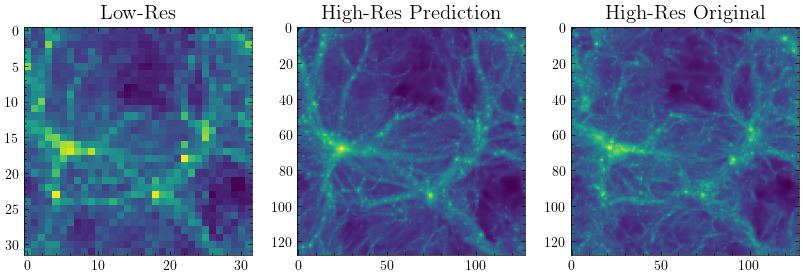

In [67]:
for epoch in range(epochs):
    for step, (_,lr_img, hr_img) in enumerate(train_iterator):
        
        lr_img, hr_img = lr_img.to(device).unsqueeze(1), hr_img.to(device).unsqueeze(1)
        optimizer.zero_grad()
        
        loss, metric = get_loss(denoising_model,
             gamma_fn,
             sample_times,
             variance_preserving_map,
             get_diffusion_loss,
             get_latent_loss,
             get_reconstruction_loss,
            x=hr_img, conditioning=lr_img)
        
        loss.backward()
        optimizer.step()
        
        if epoch % 3 == 0 and step == 0:

            print(f"Epoch {epoch} | Diffusion_loss =%.1f"%(metric['diffusion_loss'].item()))
            
            samples = gen_samples(
                    conditioning=lr_img,
                    batch_size=len(lr_img),
                    n_sampling_steps=250,
                    device=device,
                    image_shape = hr_img.shape[1:],
                    sample_zs_given_zt=sample_zs_given_zt,
                    gamma_fn = gamma_fn,
                    denoising_model = denoising_model
            )
            
            plot_samples(lr_img, hr_img, samples)

```{admonition} Exercise: Sampling Steps
:class: note

Try sampling with different numbers of reverse steps and compare output sharpness vs. runtime. Display as a grid for a particular example, where columns = number of sampling steps and rows = samples.

Comment on the image quality with an increasing number of steps. Do you always see better detail and coherence at all stages, or do you see a clear “knee” where extra steps stop helping? 

*Hint: Use the validation set through `val_iterator` to ensure reproducibility in retrieving samples.

Perform the following:

```python
with torch.no_grad():
    Ns = [1, 5, 10, 20, 50, 100]
    outs = []
    for N in Ns:
        samples = gen_samples(...,
                       n_sampling_steps=N)
        plot_samples(lr_img, hr_img, samples)

```


```{admonition} Exercise: Initial noise “temperature”
:class: note

Scale the initial Gaussian $z_{t=1}\sim \mathcal N(0, \tau^2 I)$ by a **temperature** $\tau$.
        
Describe the changes seen in the predicted samples when $\tau \gg 1$. The reverse kernels and your training objective assume a **standard-normal** endpoint. How does adding noise temperature violate this assumption? 

*Hint: The standard-normal is effectively our latent prior in high-dimensions. Recall what happens to points in high dimensions, particularly when distances are scaled -- are the points still following the prior?

```python
temps = [1, 10, 100, 1000]
outs = []

with torch.no_grad():
    for tau in temps:
        z0 = tau * torch.randn((8, *vdm.image_shape), device=device)

        zN = gen_samples(...,
                           z=z0)
        plot_samples(lr_img, hr_img, samples)
    
```